<a href="https://colab.research.google.com/github/Kim-Ziho/STUDY_NLP/blob/main/ex_RNN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 라이브러리 임포트

In [22]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

# 2. 하이퍼파라미터 셋팅

In [23]:
# Hyper-parameters 
# image tensor: (bs, 1, 28, 28)
# input tensor: (bs, n, input_size) = (bs, 28, 28)
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2

num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [24]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3. MNIST train, test dataset 가져오기

In [25]:
# MNIST dataset
mnist_train = dset.MNIST("", train=True, transform=transforms.ToTensor(),
                         target_transform=None, download=True)
mnist_test = dset.MNIST("", train=False, transform=transforms.ToTensor(),
                        target_transform=None, download=True)

# 4. 대략적인 데이터 형태

mnist_train 길이: 60000
mnist_test 길이 10000
image data 형태: torch.Size([1, 28, 28])
label: 5


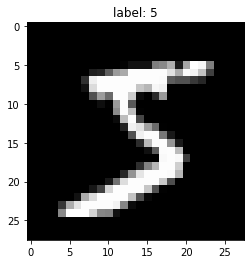

In [26]:
print("mnist_train 길이:", len(mnist_train))
print("mnist_test 길이", len(mnist_test))

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0) # 0번째 데이터
print("image data 형태:", image.size())
print("label:", label)

# 그리기
img = image.numpy() 
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

# 5. 데이터 로드 함수

In [27]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True) # batch_size 나머지는 버리기
                        
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False, # test 에서는 shuffle 하지 않음
                                          drop_last=True)

# 6. 데이터 로드함수 이해하기

[0]
한 번에 로드되는 데이터 크기: 100


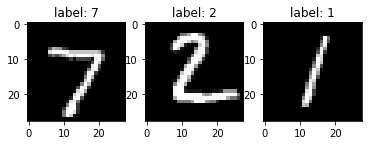

[1]
한 번에 로드되는 데이터 크기: 100


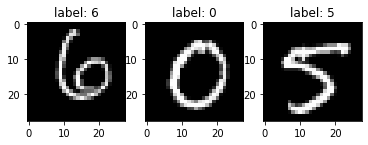

In [28]:
n = 3 # 샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(test_loader): # batch_size 만큼
    if i>1:
        break
    
    print("[%d]" %i)
    print("한 번에 로드되는 데이터 크기:", len(imgs))

    # 그리기
    for j in range(n):
        img = imgs[j].numpy() # (1, 28, 28)
        img = img.reshape((img.shape[1], img.shape[2])) # (28, 28)
        
        plt.subplot(1, n, j+1)
        plt.imshow(img, cmap='gray')
        plt.title("label: %d" %labels[j])
    plt.show()

# 7. 모델 선언

In [29]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, x):
        # input tensor: (batch_size, seq_length, input_size)
        # x: (100, 28, 28)

        # hiddent state tensor: (# of layers, batch_size, hidden_size)
        # h: (2, 100, 128)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        # output tensor: (batch_size, seq_lenth, hidden_size)
        # out: (100, 28, 128)

        out, _ = self.lstm(x, (h0, c0))

        # 28번째 output layer: (bs, hidden_size)
        # out[:, -1, :]: (100. 128)

        out = self.fc(out[:, -1, :])

        # y^: (batch_size, num_classes)
        # y_pred: (100, 10)

        return out

In [30]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [31]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0

    for j, [imgs, labels] in enumerate(dloader): # batch_size 만큼
        # x: (batch_size, 1, img_width, img_height) -> (batch_size, seq_length, input_size)
        img = imgs
        img = img.reshape(-1, sequence_length, input_size).to(device)

        # y: (batch_size, num_classes)
        label = labels.to(device)

        # Forward prop
        output = imodel(img) # (batch_size, num_classes)
        _, output_index = torch.max(output, 1) # (batch_size, 1)

        total += label.size(0)
        correct += (output_index == label).sum().float()
    return (100*correct/total).numpy()

print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 11.08


# 8. loss, optimizer

In [32]:
# Loss and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 9. 학습

In [33]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, [imgs, labels] in enumerate(train_loader):
        # x: (batch_size, 1, img_width, img_height) -> (batch_size, seq_length, input_size)
        img = imgs
        img = img.reshape(-1, sequence_length, input_size).to(device)

        # y: (batch_size, num_classes)
        label = labels.to(device)

        # Forward prop
        outputs = model(img)
        loss = loss_func(outputs, label)

        # Backward prop & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accr: {:.2f}'.
                  format(epoch+1, num_epochs, 
                         i+1, total_step,
                         loss.item(),
                         ComputeAccr(test_loader, model)))

Epoch [1/2], Step [100/600], Loss: 0.2892, Accr: 85.13
Epoch [1/2], Step [200/600], Loss: 0.1574, Accr: 92.92
Epoch [1/2], Step [300/600], Loss: 0.1229, Accr: 93.19
Epoch [1/2], Step [400/600], Loss: 0.2608, Accr: 96.41
Epoch [1/2], Step [500/600], Loss: 0.0640, Accr: 96.28
Epoch [1/2], Step [600/600], Loss: 0.1249, Accr: 96.73
Epoch [2/2], Step [100/600], Loss: 0.0513, Accr: 97.21
Epoch [2/2], Step [200/600], Loss: 0.0936, Accr: 97.17
Epoch [2/2], Step [300/600], Loss: 0.1260, Accr: 97.33
Epoch [2/2], Step [400/600], Loss: 0.1725, Accr: 96.83
Epoch [2/2], Step [500/600], Loss: 0.2180, Accr: 96.77
Epoch [2/2], Step [600/600], Loss: 0.1186, Accr: 97.33


# 10. 테스트

In [34]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 97.33


# 11. 학습된 파라미터 저장

In [36]:
netname = 'drive/MyDrive/nets/rnn_mnist_weight.pkl'
torch.save(model, netname)

# 12. 학습된 파라미터 로드

In [39]:
netname = 'drive/MyDrive/nets/rnn_mnist_weight.pkl'
model = torch.load(netname)

In [41]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 97.33
